#### 

##### Deep Learning

### Done by Wael Farag


## Project: Build a Traffic Sign Recognition Classifier


This script is mainly to test the trainined CNN "WAF_LeNet_v1" using some collected samples of German traffic-sign images downloaded from the web.  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten

%matplotlib inline

Image_path  = "C:/work/MyFiles/Research/DeepLearning/CarND/TrafficSign/German_Traffic_Signs_from_Web/"
Model_path = "C:/work/MyFiles/Research/DeepLearning/CarND/TrafficSign/traffic-signs-model/"

##### Some Function Definitions


In [2]:
def Convert_Color2Gray(color_image):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    Scaled_image_data = a + (((image_data - grayscale_min) * (b - a)) / (grayscale_max - grayscale_min))

    return Scaled_image_data

### The Main Function for Network Architecture 

In [3]:
def WAF_LeNet_v1(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1 (grey scale). Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1 , 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC', name='Conv1')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.

    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1] , strides=[1, 2, 2, 1], padding='VALID', data_format='NHWC', name='Conv2')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)

    pkeep = 1.0                                  # keep probability for dropout layer for evalution only
    FC1_size = 300                               # First Fully connected Layer
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = FC1_size.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, FC1_size), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(FC1_size))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Added Drop-out Layer here
    fc1 = tf.nn.dropout(fc1, pkeep)               # pkeep = 0.75

    FC2_size = 150                                # Second Fully connected Layer
    
    # SOLUTION: Layer 4: Fully Connected. Input = FC1_size. Output = FC2_size.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(FC1_size, FC2_size), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(FC2_size))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Added Drop-out Layer here
    fc2 = tf.nn.dropout(fc2, pkeep)                         # pkeep = 0.75

    # SOLUTION: Layer 5: Fully Connected. Input = FC2_size. Output = 43 (n_classes).
    fc3_W = tf.Variable(tf.truncated_normal(shape=(FC2_size, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

Defining Features and Labels for Model Evaluation

In [4]:
#================================================================================================
#                                    Features and Labels
#================================================================================================
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
#================================================================================================
#                                       Model Evaluation
#================================================================================================
logits = WAF_LeNet_v1(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Evalution Functions

In [5]:
def evaluate(X_data, y_data):
    sess = tf.get_default_session()
    accuracy = sess.run(accuracy_operation, feed_dict={x: X_data, y: y_data})
    return accuracy


def Top_Softmax (X_test, sess):
    Probabilities = sess.run(tf.nn.softmax(logits), feed_dict={x: X_test})
    Top_5_Softmax = tf.nn.top_k(Probabilities, k=5)
    return sess.run(Top_5_Softmax)

### Feature Map Drawing

In [6]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### The Main Evaluation Routine

Loops on all the images in a certain folder and evaluates them

Test Accuracy of Sign ID# 1 = 1.000


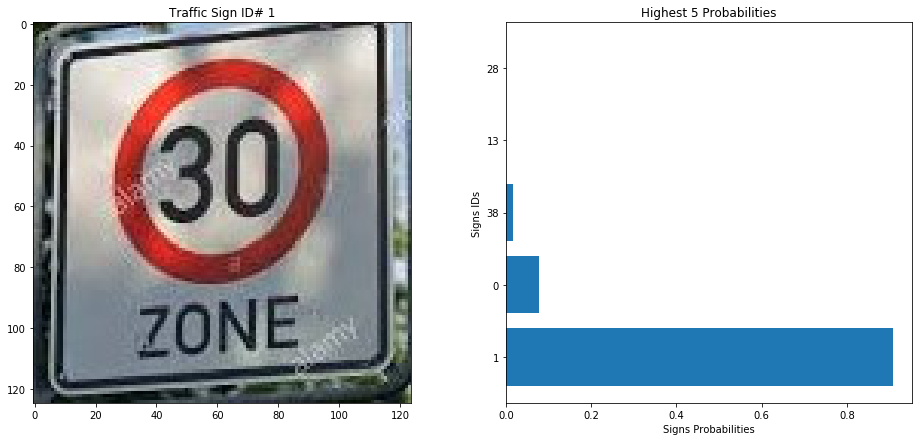

1st Convonutional Layer Output Feature Map


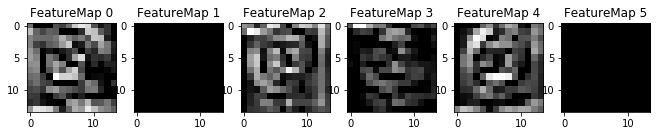

Test Accuracy of Sign ID# 17 = 1.000


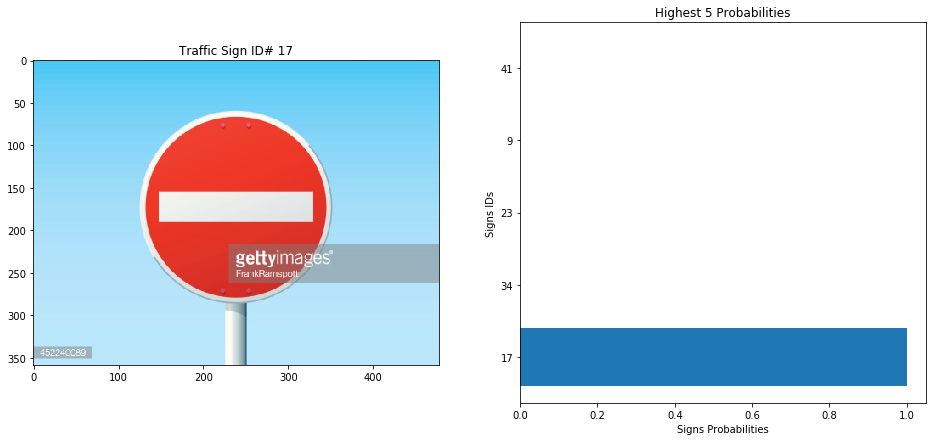

1st Convonutional Layer Output Feature Map


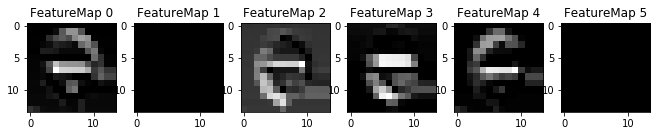

Test Accuracy of Sign ID# 18 = 1.000


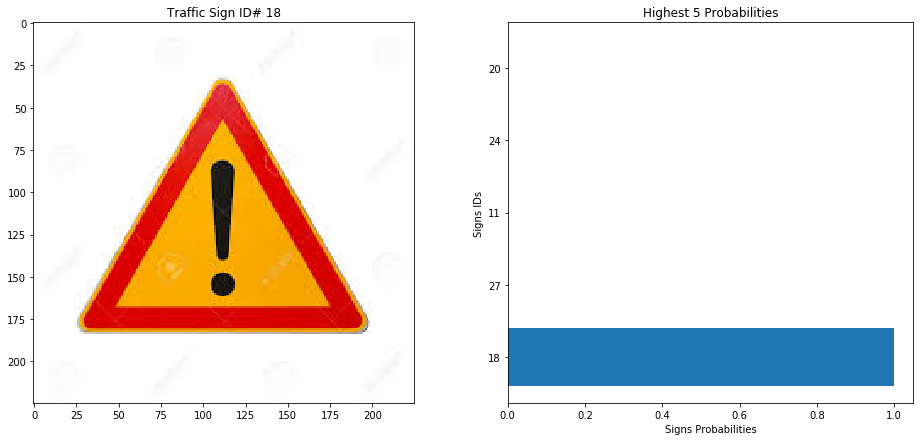

1st Convonutional Layer Output Feature Map


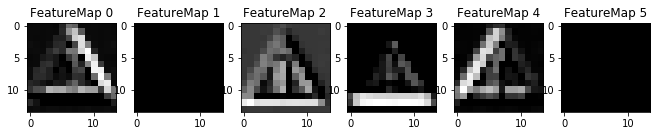

Test Accuracy of Sign ID# 22 = 1.000


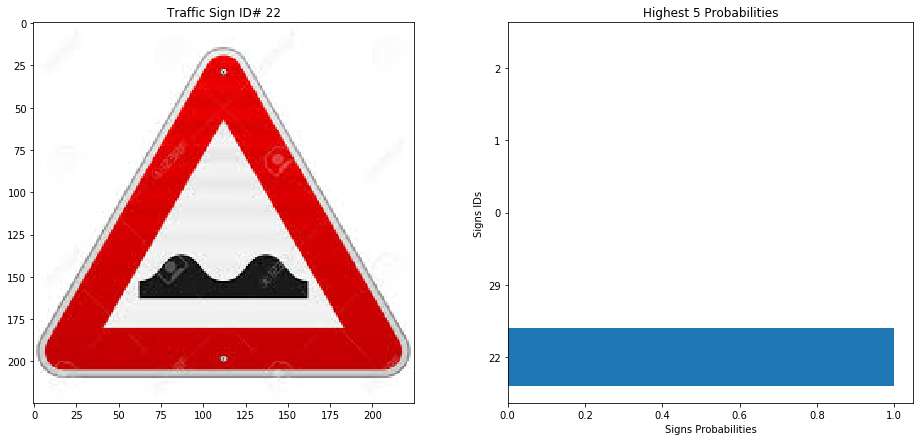

1st Convonutional Layer Output Feature Map


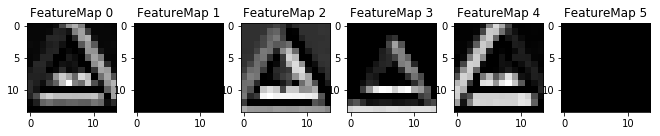

Test Accuracy of Sign ID# 25 = 1.000


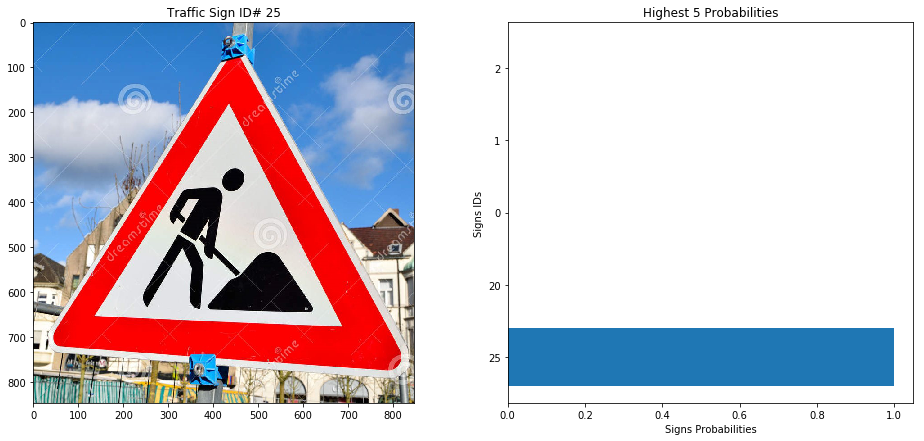

1st Convonutional Layer Output Feature Map


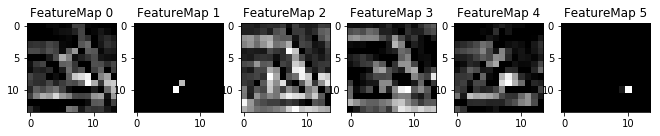

Test Accuracy of Sign ID# 26 = 1.000


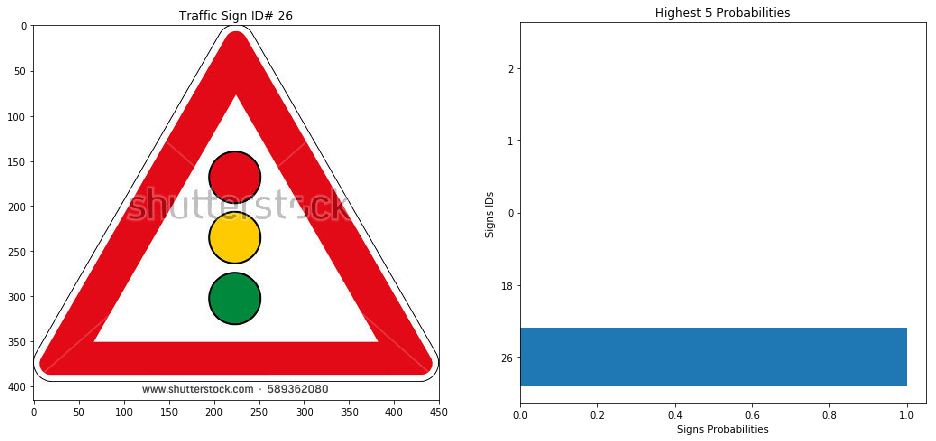

1st Convonutional Layer Output Feature Map


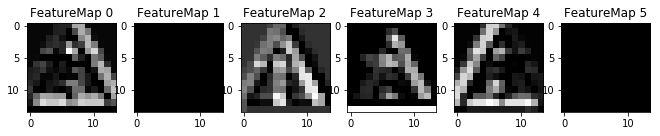

Test Accuracy of Sign ID# 3 = 1.000


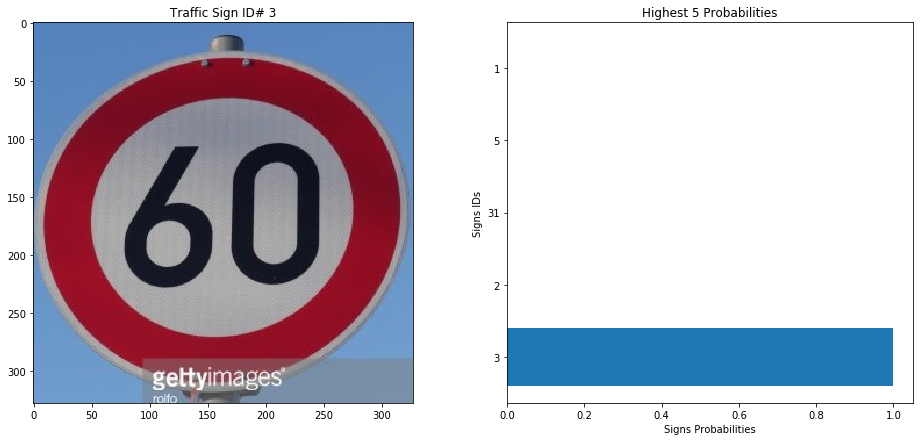

1st Convonutional Layer Output Feature Map


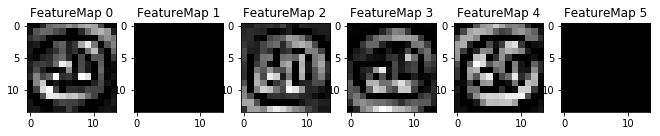

Test Accuracy of Sign ID# 33 = 1.000


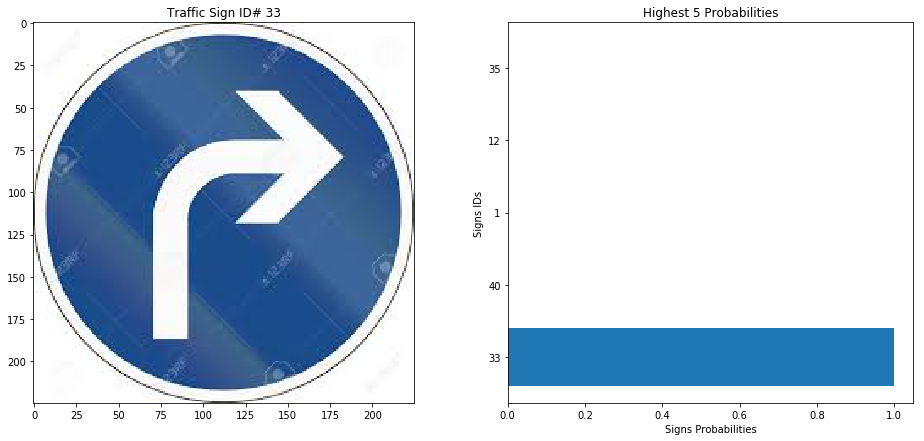

1st Convonutional Layer Output Feature Map


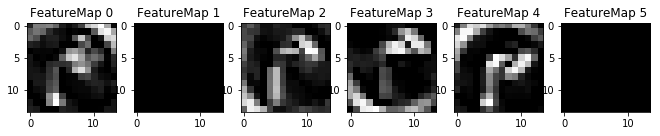

Test Accuracy of Sign ID# 35 = 1.000


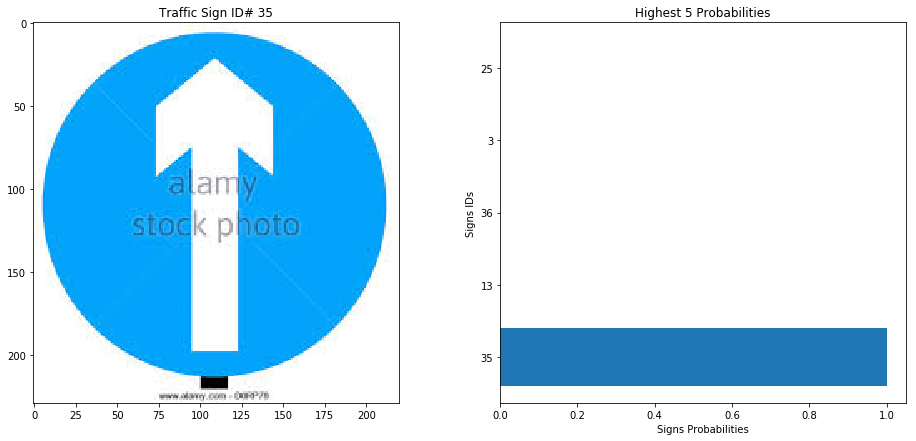

1st Convonutional Layer Output Feature Map


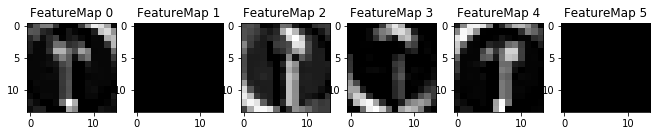

Test Accuracy of Sign ID# 40 = 1.000


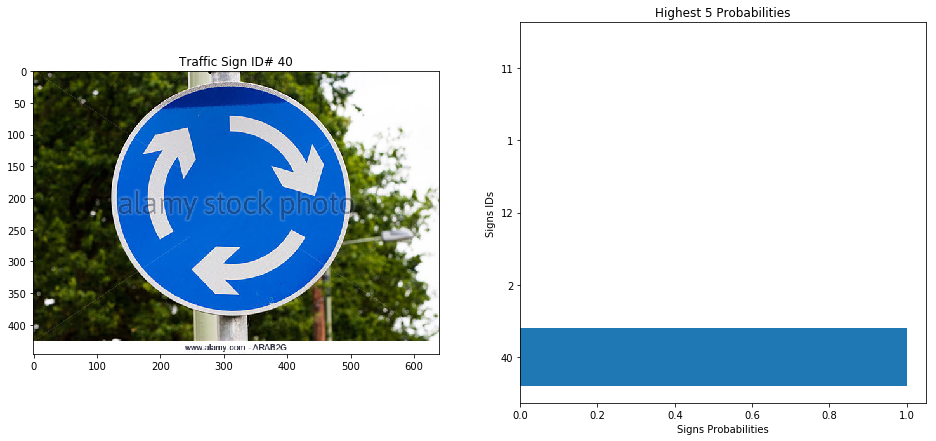

1st Convonutional Layer Output Feature Map


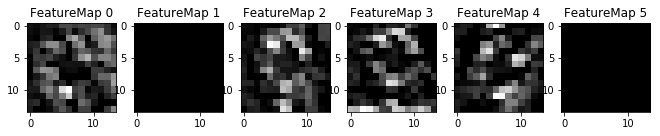

In [7]:
#=============================================================================================
#---------------------------------  Evaluate the Model  --------------------------------------
#=============================================================================================


for image_file_name in os.listdir(Image_path):
    image = mpimg.imread(Image_path + image_file_name)
    filename, extention = image_file_name.split(".")
    y_test = [int(filename)]
    resized_image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_LINEAR)
    gray_image = Convert_Color2Gray(resized_image)
    normalized_image = normalize_grayscale(gray_image)
    X_test = np.reshape(normalized_image, [1, 32 ,32,1])
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(Model_path + '.'))
        test_accuracy = evaluate(X_test, y_test)
        print("Test Accuracy of Sign ID# {} = {:.3f}".format(int(filename), test_accuracy))
        Sign_Top_5_Prop = Top_Softmax(X_test, sess)
        #print("Sign_Top_5_Prop =", Sign_Top_5_Prop)
        #print(np.shape(Sign_Top_5_Prop.values))
        plt.figure(figsize=(16, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Traffic Sign ID# '+ filename)
        # plt.show()
        plt.subplot(1, 2, 2)
        plt.barh(np.arange(1, 6, 1), Sign_Top_5_Prop.values[0,:])
        plt.title('Highest 5 Probabilities')
        plt.yticks(np.arange(1, 6, 1), Sign_Top_5_Prop.indices[0,:])
        plt.ylabel('Signs IDs')
        plt.xlabel('Signs Probabilities')
        plt.show()
        print('1st Convonutional Layer Output Feature Map')
        tf_activation = tf.get_default_graph().get_tensor_by_name('Conv1:0')
        outputFeatureMap(X_test, tf_activation, activation_min=-1, activation_max=-1, plt_num=1)
        plt.show()
        print("=========================================================================================================================")

#============================================================================================